In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.autograd as ag
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from copy import deepcopy

In [ ]:
# !pip install gymnasium
# import gymnasium as gym

#this is for future applications

In [ ]:
seed = 189
plot = True
innerstepsize = 0.02 # stepsize in inner SGD
innerepochs = 1
outerstepsize0 = 0.1 # stepsize of meta-optimization
iterations = 50000 # number of outer updates; each iteration we sample one task and update on it

rng = np.random.RandomState(seed)
torch.manual_seed(seed)

In [ ]:
x_range = np.linspace(-5, 5, 50)[:,None] # All of the x points
ntrain = 10 # Size of training minibatches
def gen():
    #sine wave classification with few examples
    phase = rng.uniform(low=0, high=2*np.pi)
    ampl = rng.uniform(0.1, 5)
    f_randomsine = lambda x : np.sin(x + phase) * ampl
    return f_randomsine

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 64),
    nn.Tanh(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, 1)
)
#training 

In [ ]:
def train(x, y):
  #batch gradient descent
  x = torch.Tensor(x)
  y = torch.Tensor(y)
  model.zero_grad()
  pred = model(x)
  loss = (pred-y).pow(2).mean() #nn.MSELoss has some weird behaviors, therefore I found hard-coding it is easier
  loss.backward()
  for param in model.parameters():
        param.data -= innerstepsize * param.grad.data #vanilla gradient descent, not to be confused with GD in MAML

def forward(x):
  x = torch.tensor(x, dtype=torch.float32) #resolves dtype errors
  output = model(x)
  return output.data.numpy()

In [ ]:
f_plot = gen()
xtrain_plot = x_range[rng.choice(len(x_range), size=ntrain)]

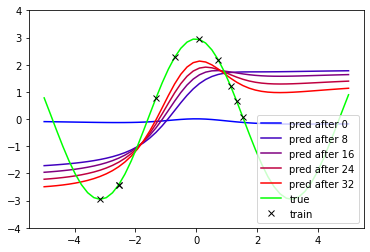

-----------------------------
iteration               2
loss on plotted curve   3.613


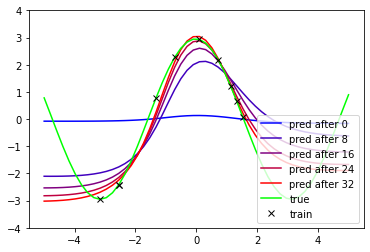

-----------------------------
iteration               2
loss on plotted curve   1.336


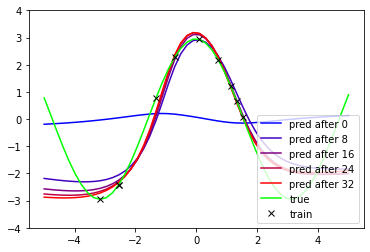

-----------------------------
iteration               2
loss on plotted curve   1.202


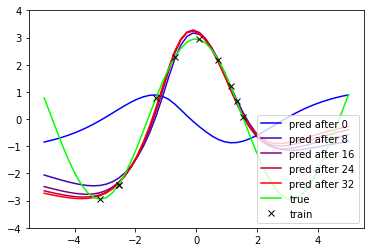

-----------------------------
iteration               2
loss on plotted curve   1.359


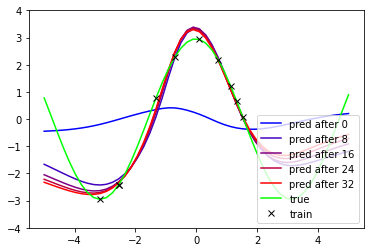

-----------------------------
iteration               2
loss on plotted curve   0.953


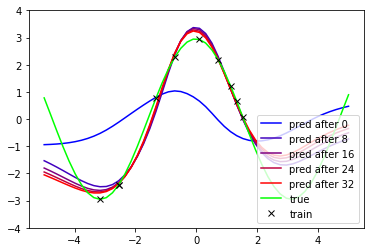

-----------------------------
iteration               2
loss on plotted curve   0.860


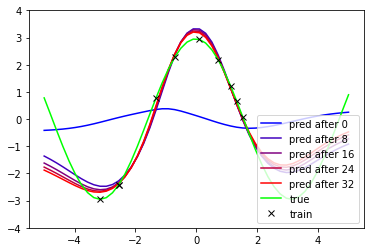

-----------------------------
iteration               2
loss on plotted curve   0.643


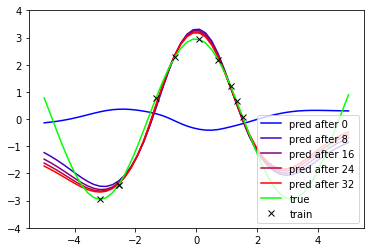

-----------------------------
iteration               2
loss on plotted curve   0.552


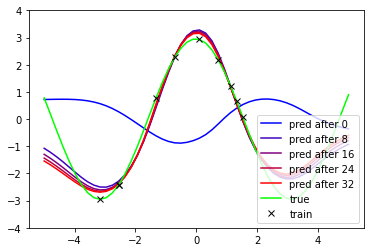

-----------------------------
iteration               2
loss on plotted curve   0.454


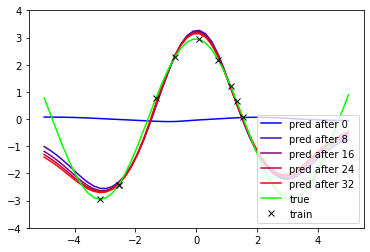

-----------------------------
iteration               2
loss on plotted curve   0.412


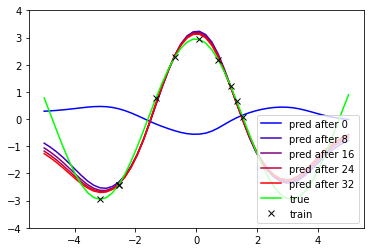

-----------------------------
iteration               2
loss on plotted curve   0.337


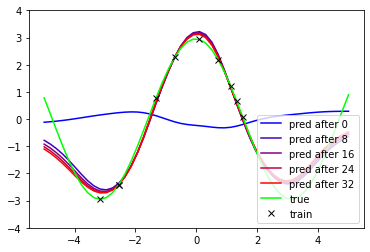

-----------------------------
iteration               2
loss on plotted curve   0.285


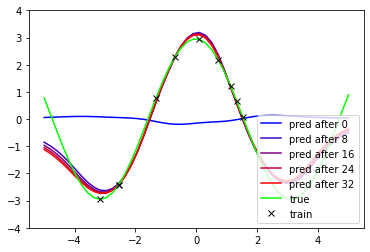

-----------------------------
iteration               2
loss on plotted curve   0.281


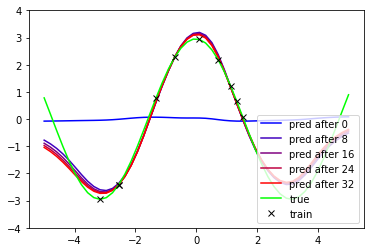

-----------------------------
iteration               2
loss on plotted curve   0.257


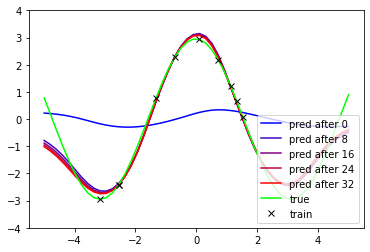

-----------------------------
iteration               2
loss on plotted curve   0.241


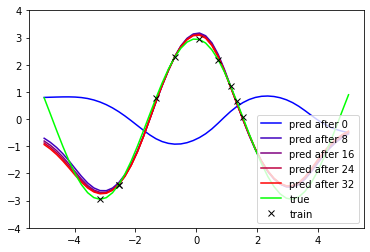

-----------------------------
iteration               2
loss on plotted curve   0.216


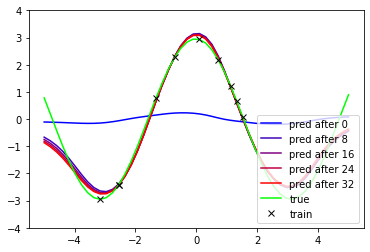

-----------------------------
iteration               2
loss on plotted curve   0.195


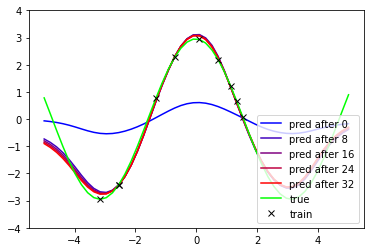

-----------------------------
iteration               2
loss on plotted curve   0.190


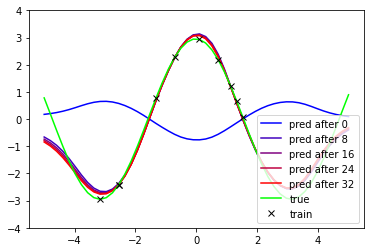

-----------------------------
iteration               2
loss on plotted curve   0.177


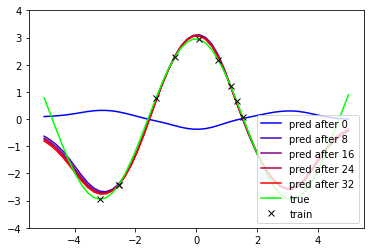

-----------------------------
iteration               2
loss on plotted curve   0.175


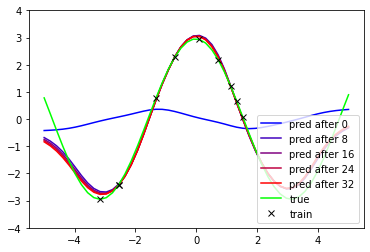

-----------------------------
iteration               2
loss on plotted curve   0.176


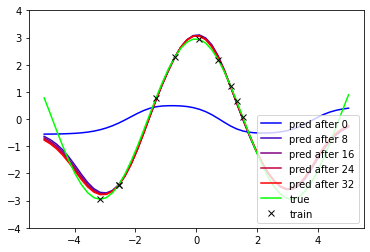

-----------------------------
iteration               2
loss on plotted curve   0.161


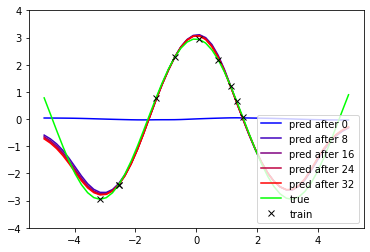

-----------------------------
iteration               2
loss on plotted curve   0.153


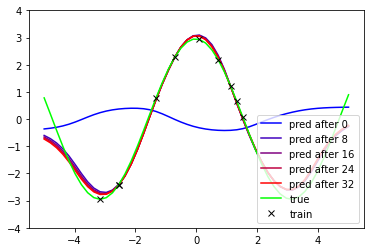

-----------------------------
iteration               2
loss on plotted curve   0.147


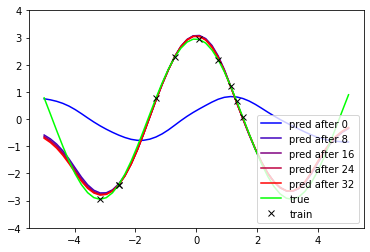

-----------------------------
iteration               2
loss on plotted curve   0.141


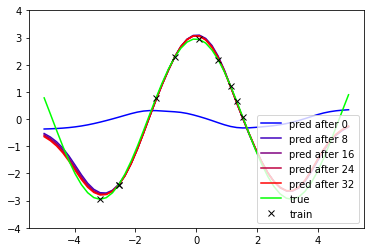

-----------------------------
iteration               2
loss on plotted curve   0.134


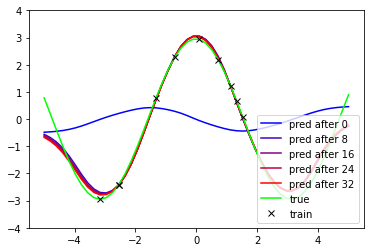

-----------------------------
iteration               2
loss on plotted curve   0.133


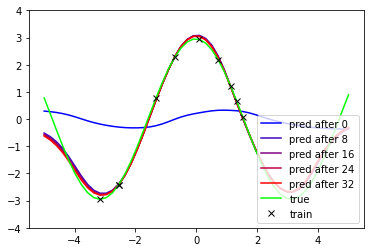

-----------------------------
iteration               2
loss on plotted curve   0.128


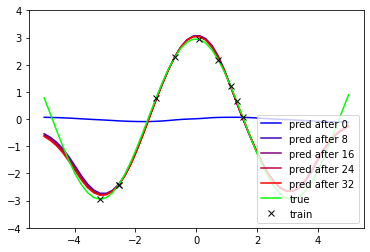

-----------------------------
iteration               2
loss on plotted curve   0.130


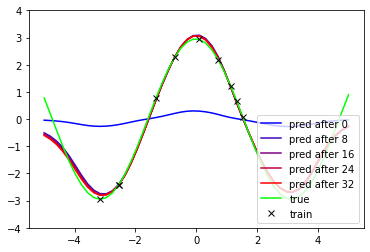

-----------------------------
iteration               2
loss on plotted curve   0.121


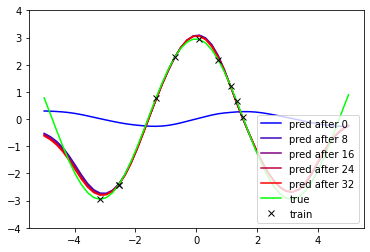

-----------------------------
iteration               2
loss on plotted curve   0.120


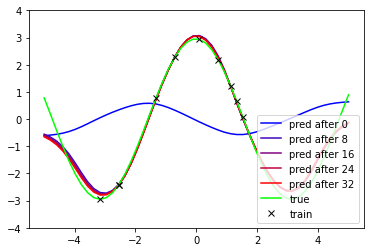

-----------------------------
iteration               2
loss on plotted curve   0.124


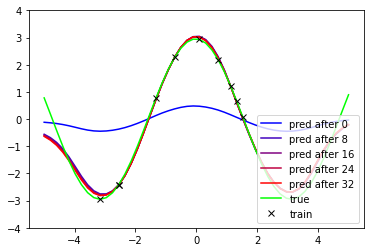

-----------------------------
iteration               2
loss on plotted curve   0.120


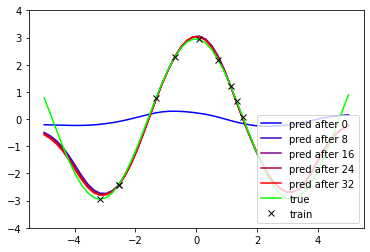

-----------------------------
iteration               2
loss on plotted curve   0.115


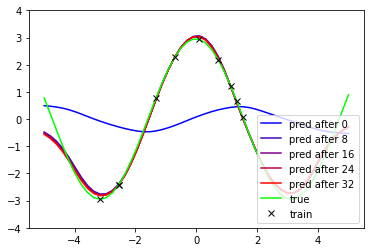

-----------------------------
iteration               2
loss on plotted curve   0.113


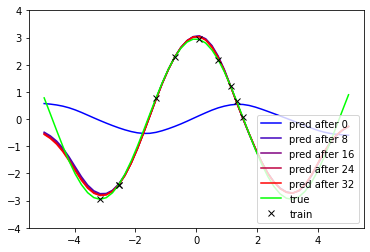

-----------------------------
iteration               2
loss on plotted curve   0.111


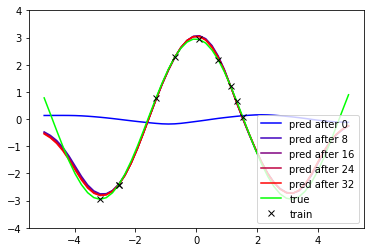

-----------------------------
iteration               2
loss on plotted curve   0.108


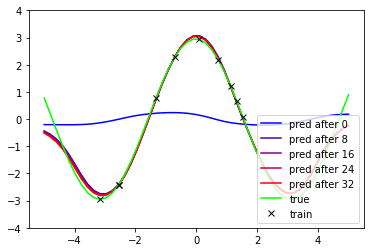

-----------------------------
iteration               2
loss on plotted curve   0.106


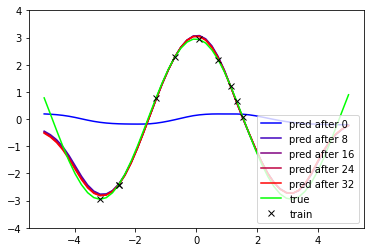

-----------------------------
iteration               2
loss on plotted curve   0.106


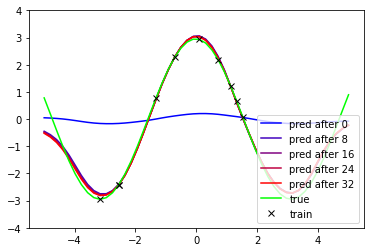

-----------------------------
iteration               2
loss on plotted curve   0.105


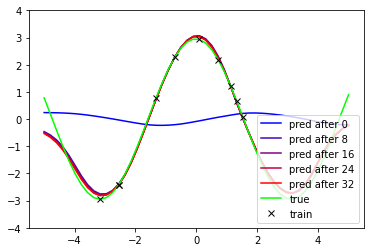

-----------------------------
iteration               2
loss on plotted curve   0.105


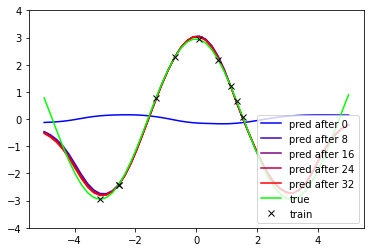

-----------------------------
iteration               2
loss on plotted curve   0.104


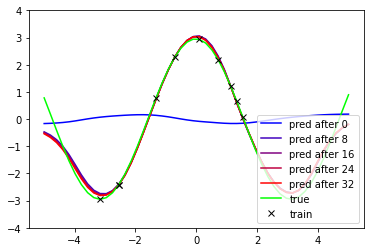

-----------------------------
iteration               2
loss on plotted curve   0.105


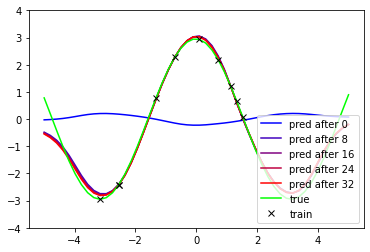

-----------------------------
iteration               2
loss on plotted curve   0.104


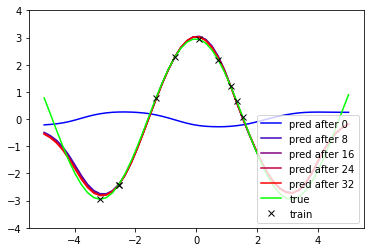

-----------------------------
iteration               2
loss on plotted curve   0.105


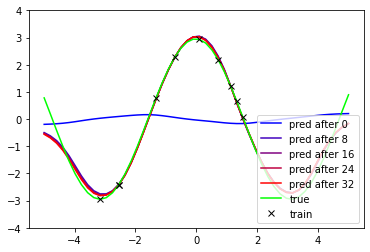

-----------------------------
iteration               2
loss on plotted curve   0.105


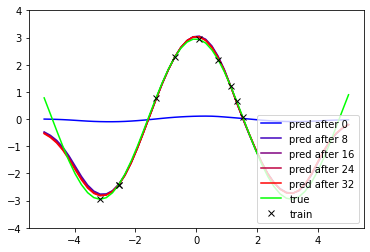

-----------------------------
iteration               2
loss on plotted curve   0.103


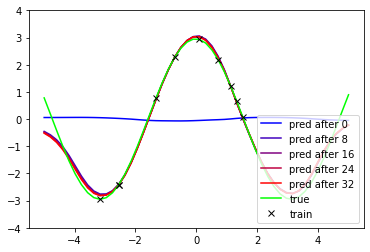

-----------------------------
iteration               2
loss on plotted curve   0.102


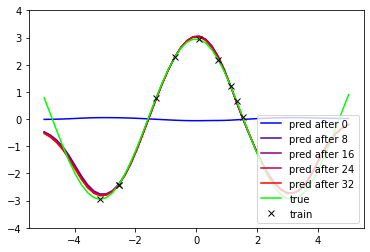

-----------------------------
iteration               2
loss on plotted curve   0.102


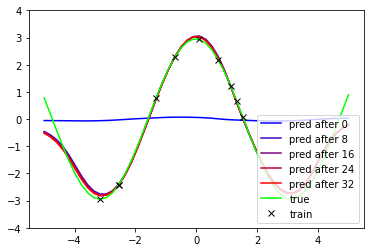

-----------------------------
iteration               2
loss on plotted curve   0.102


In [ ]:
for i in range(iterations):
  weights_before = deepcopy(model.state_dict())
  # Generate datapoints for task
  f = gen()
  y_all = f(x_range)
  # Do SGD on this task
  inds = rng.permutation(len(x_range))
  for _ in range(innerepochs):
      for start in range(0, len(x_range), ntrain):
          mbinds = inds[start:start+ntrain]
          train(x_range[mbinds], y_all[mbinds])
  weights_after = model.state_dict()
  outerstepsize = outerstepsize0 * (1 - i / iterations) # linear schedule/gradient decay
  model.load_state_dict({name : 
      weights_before[name] + (weights_after[name] - weights_before[name]) * outerstepsize 
      for name in weights_before}) #REPTILE
  #weights_after - weights_before is the meta-gradient, and we multiply by a linear term

  #I left plotting to its own devices: it's better to use what openAI has already implemented for us
  if not i % 1000:
    plt.cla()
    f = f_plot #even though this is just one specific dataset, we can still use it for our purposes
    weights_before = deepcopy(model.state_dict()) # save snapshot before evaluation
    plt.plot(x_range, forward(x_range), label="pred after 0", color=(0,0,1))
    for inneriter in range(32):
        train(xtrain_plot, f(xtrain_plot))
        if (inneriter+1) % 8 == 0:
            frac = (inneriter+1) / 32
            plt.plot(x_range, forward(x_range), label="pred after %i"%(inneriter+1), color=(frac, 0, 1-frac))
    plt.plot(x_range, f(x_range), label="true", color=(0,1,0))
    lossval = np.square(forward(x_range) - f(x_range)).mean()
    plt.plot(xtrain_plot, f(xtrain_plot), "x", label="train", color="k")
    plt.ylim(-4,4)
    plt.legend(loc="lower right")
    plt.pause(0.01)
    model.load_state_dict(weights_before) # restore from snapshot
    print(f"-----------------------------")
    print(f"iteration               {innerepochs+1}")
    print(f"loss on plotted curve   {lossval:.3f}") # would be better to average loss over a set of examples, but this is optimized for brevity